In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from d2l import torch as d2l

train_data = pd.read_csv('/Users/linzheng/Desktop/Study-pytorch/My_d2l_learn/data/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('/Users/linzheng/Desktop/Study-pytorch/My_d2l_learn/data/house-prices-advanced-regression-techniques/test.csv')
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [2]:
# 数据预处理 x=x-mean/std
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features = all_features.fillna(0)
# 将离散数值转换为指示特征 独热编码
all_features = pd.get_dummies(all_features, dummy_na=True, dtype=int)
print(all_features.shape)

(2919, 353)


In [3]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float32).view(-1, 1)
print(train_features.shape, test_features.shape, train_labels.shape)

torch.Size([1460, 353]) torch.Size([1459, 353]) torch.Size([1460, 1])


In [4]:
# 训练模型
loss = nn.MSELoss()
in_features = train_features.shape[1]
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

In [5]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

# K折交叉验证
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs], legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, 平均验证log rmse: {float(valid_l):f}')

In [6]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch', ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('/Users/linzheng/Desktop/Study-pytorch/My_d2l_learn/data/house-prices-advanced-regression-techniques/submission.csv', index=False)

train log rmse 0.130586


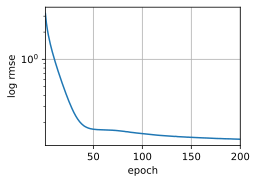

In [21]:
num_epochs, lr, weight_decay, batch_size = 200, 7, 0.0001, 64
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)